# Step 0 -- get the data

In [1]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip -O data.zip

--2016-12-27 10:35:04--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 54.230.216.219, 54.230.216.170, 54.230.216.189, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|54.230.216.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: 'data.zip'

100%[======================================>] 333,137,665 20.9MB/s   in 19s    

2016-12-27 10:35:23 (16.6 MB/s) - 'data.zip' saved [333137665/333137665]



In [2]:
!unzip -q data.zip
!mv data udacity_data
!rm -rf __MACOSX/

In [1]:
DATA_FOLDER = 'udacity_data/'

# Step 1 -- data generator

In [2]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [3]:
log_source = pd.read_csv(DATA_FOLDER + 'driving_log.csv')
log_nonzero = log_source[log_source.steering != 0]
log_zero = (log_source[log_source.steering == 0]).sample(frac=.1)

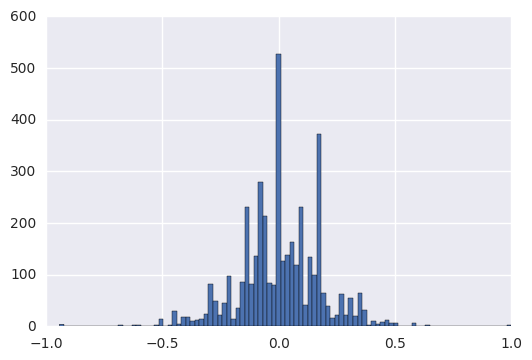

In [4]:
log = pd.concat([log_nonzero, log_zero], ignore_index=True)
log.steering.hist(bins=100)

In [5]:
input_shape = (64, 64, 3)

In [6]:
def _get_img_and_steering_from_row(row):
#     way, shift = np.random.randint(-1, 2), 0.15
#     imgpath = row[['right', 'center', 'left'][way + 1]].values[0]
#     imgpath = imgpath[imgpath.find('IMG'):]
#     img = cv2.imread(DATA_FOLDER + imgpath)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     steering = row.steering.values[0] + way * shift
    imgpath = row.center.values[0]
    imgpath = imgpath[imgpath.find('IMG'):]
    img = cv2.imread(DATA_FOLDER + imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    steering = row.steering.values[0]
    return img, steering


def _get_flipped_image(img, y):
    img = cv2.flip(img, 1)
    return img, -y


def _get_brightnessed_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    img[:,:,2] = img[:,:,2] * random_bright
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img


def _get_translated_image(img, y, trans_range=20):
    tr_x = trans_range * np.random.uniform() - trans_range/2
    y = y + tr_x/trans_range * 2 *.2
    tr_y = trans_range * np.random.uniform() - trans_range/2
    Trans_M = np.float32([[1,0, tr_x], [0,1, tr_y]])
    img = cv2.warpAffine(img, Trans_M, (input_shape[1], input_shape[0]))
    return img, y


def image_augmentation(img, y):
    if np.random.uniform() < 0.5:
        img, y = _get_flipped_image(img, y)
    img = _get_brightnessed_image(img)
    img, y = _get_translated_image(img, y)
    return img, y


def image_transformation(img):
    img = img[60:-20,:,:]
    img = cv2.resize(img, (input_shape[1], input_shape[0]), interpolation=cv2.INTER_AREA)
    return img

In [7]:
def data_generator(data, batch_size):
    while True:
        X = np.zeros((batch_size, *input_shape), dtype=np.float32)
        y = np.zeros((batch_size,), dtype=np.float32)
        for idx in range(batch_size):
            row = data.sample()
            img, steering = _get_img_and_steering_from_row(row)
            img = image_transformation(img)
            img, steering = image_augmentation(img, steering)
            X[idx], y[idx] = img, steering
        yield X, y

# Step 2 -- define the model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, ELU, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


Big thanks to [Vivek Yadav](https://github.com/vxy10/P3-BehaviorCloning) for sharing his architecture!

In [9]:
def get_vivek_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
    model.add(Convolution2D(3,1,1,  border_mode='valid', name='conv0', init='he_normal'))
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv1', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv2', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv3', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv4', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv5', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv6', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512,name='hidden1', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(64,name='hidden2', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(16,name='hidden3',init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(1, name='output', init='he_normal'))
    model.compile(optimizer="adam", loss="mse")
    return model

In [10]:
model = get_vivek_model()
model.fit_generator(
    data_generator(log, 50),
    samples_per_epoch=20000,
    nb_epoch=10
)

Epoch 1/10
20000/20000 [==============================] - 35s - loss: 0.0360      

In [11]:
for _ in range(10):
    i = np.random.randint(len(log))
    img = DATA_FOLDER + log.iloc[i].center
    img = np.expand_dims(image_transformation(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)), axis=0)
    print(log.iloc[i].steering, model.predict(img)[0])

0.05219137 [ 0.20048791]
0.0 [-0.0093522]
-0.0787459 [-0.08411984]
-0.08824026 [-0.03180486]
0.1670138 [ 0.29538104]
0.1765823 [ 0.06491703]
0.004348711 [ 0.05268262]
-0.05975719 [-0.02281168]
0.0 [-0.11909606]
0.2626991 [ 0.12210006]


In [ ]:
import json
with open('model.json', 'w') as f:
    f.write(model.to_json())
model.save_weights('model.h5')

Damn this one is so close! Failed on test set :(